In [1]:
import sys
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
REPO = join(os.getenv("REPO"), "ukbb_gwas/bin")
sys.path.insert(0, REPO)

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from dataloader import VariantLoader, EmbeddingLoader, ExomeLoader
from utils import check_ram

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [2]:
multilabel_matrix_path = "/orange/sai.zhang/UKBB/finngen/label_matrix.npy"
sample_path = "/orange/sai.zhang/UKBB/finngen/sample_uid.txt"
variant_db = join(os.getenv("PROCESSED_DATA"), "processed/sqlite/ukbb_sample_indexed_merged2.db")
embedding_db = join(os.getenv("PROCESSED_DATA"), "processed/embeddings/protein_embeddings.h5")

In [3]:
eur_samples = VariantLoader(variant_db, "merged_variants").get_all_samples()
multilabel_matrix = np.load(multilabel_matrix_path)
sample_ids = pd.read_csv(sample_path, header = None).to_numpy().flatten()
id2index = {sample_id: index for index, sample_id in enumerate(sample_ids)}
eur_indices = [id2index[sample_id] for sample_id in eur_samples if sample_id in id2index]
eur_multilabel_matrix = multilabel_matrix[eur_indices]
eur_id2index = {sample_id: index for index, sample_id in enumerate(eur_samples)}
eur_index2id = {index : sample_id  for index, sample_id in enumerate(eur_samples)}

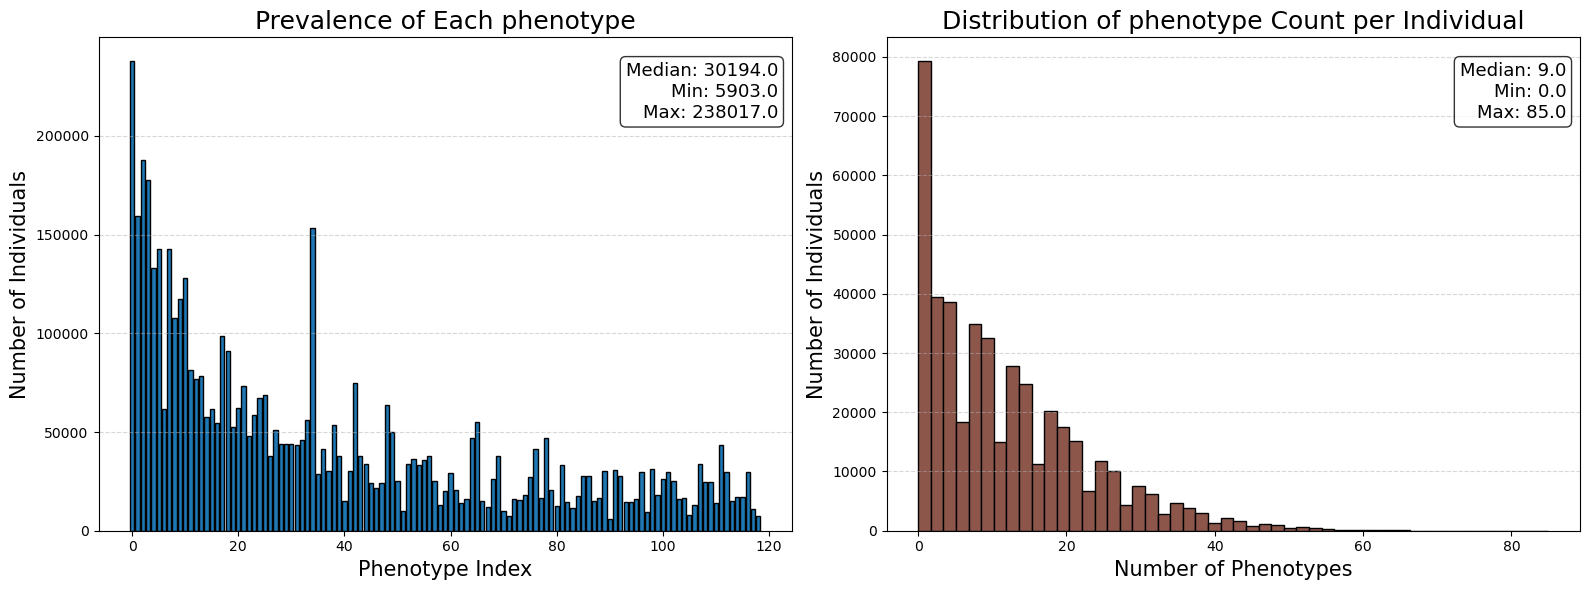

In [4]:
phenotype_counts = eur_multilabel_matrix.sum(axis=0)
person_phenotype_counts = eur_multilabel_matrix.sum(axis=1)

def get_stats(arr):
    return f"Median: {np.median(arr):.1f}\nMin: {arr.min()}\nMax: {arr.max()}"

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

title_size = 18
label_size = 15
stats_size = 13

# Left: phenotype prevalence
axs[0].bar(np.arange(eur_multilabel_matrix.shape[1]), phenotype_counts, color='tab:blue',edgecolor='black')
axs[0].set_title("Prevalence of Each phenotype", fontsize=title_size)
axs[0].set_xlabel("Phenotype Index", fontsize=label_size)
axs[0].set_ylabel("Number of Individuals", fontsize=label_size)
axs[0].grid(axis='y', linestyle='--', alpha=0.5)
axs[0].text(0.98, 0.95, get_stats(phenotype_counts), transform=axs[0].transAxes,
            ha='right', va='top', fontsize=stats_size,
            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

# Right: phenotypes per person
axs[1].hist(person_phenotype_counts, bins=50, color='tab:brown', edgecolor='black')
axs[1].set_title("Distribution of phenotype Count per Individual", fontsize=title_size)
axs[1].set_xlabel("Number of Phenotypes", fontsize=label_size)
axs[1].set_ylabel("Number of Individuals", fontsize=label_size)
axs[1].grid(axis='y', linestyle='--', alpha=0.5)
axs[1].text(0.98, 0.95, get_stats(person_phenotype_counts), transform=axs[1].transAxes,
            ha='right', va='top', fontsize=stats_size,
            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


### Split to 10 sets

In [5]:
mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
splits = list(mskf.split(eur_samples, eur_multilabel_matrix))
sample_subsets = []
phenotype_counts_subsets = []
for _, indices in splits:
    sample_subsets.append(indices)
    phenotype_counts = eur_multilabel_matrix[indices].sum(axis=0)
    phenotype_counts_subsets.append(phenotype_counts)

### Use 80% train, 10% val, 10% test

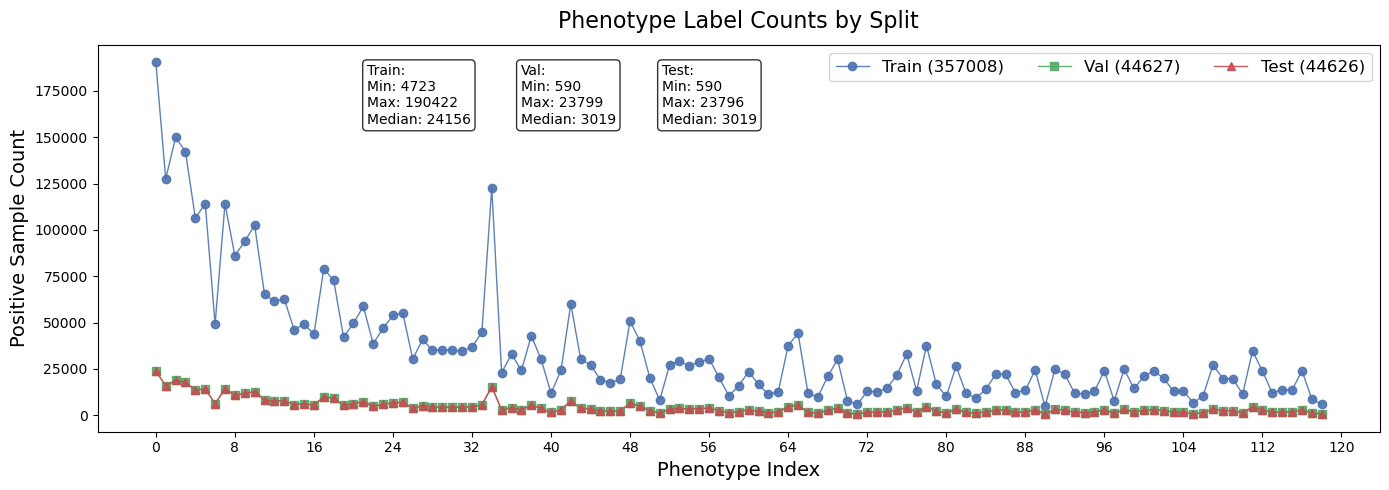

In [6]:
train_index = np.array(sample_subsets[:8]).flatten()
val_index, test_index = sample_subsets[-2:]
train_counts = np.array(phenotype_counts_subsets[:8]).flatten() 
val_counts, test_counts = phenotype_counts_subsets[-2:]

# train_index, temp_index = train_test_split(np.concatenate([disease_indices, healthy_indices]),\
#                                                train_size=1/3, random_state = 1809, shuffle = True)
# val_index, test_index = train_test_split(temp_index, test_size=0.5)

phenotype_counts_subsets = []
for indices in [train_index, val_index, test_index]:
    phenotype_counts = eur_multilabel_matrix[indices].sum(axis=0)
    phenotype_counts_subsets.append(phenotype_counts)
train_counts, val_counts, test_counts = phenotype_counts_subsets[:3]

# prepare for plotting
splits_info = [
    ('Train', train_index, train_counts, 'o'),
    ('Val',   val_index,   val_counts,   's'),
    ('Test',  test_index,  test_counts,  '^'),
]

def add_stats_box(ax, counts, label, xpos):
    min_val = int(np.min(counts))
    max_val = int(np.max(counts))
    median_val = int(np.median(counts))
    textstr = f"{label}:\nMin: {min_val}\nMax: {max_val}\nMedian: {median_val}"
    
    ax.text(
        xpos,  # X position
        0.95,  # Y relative position
        textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

plt.style.use('seaborn-v0_8-deep')
fig, ax = plt.subplots(figsize=(14, 5))

for name, idx, cnt, marker in splits_info:
    ax.plot(
        np.arange(len(cnt)),  # phenotype indices
        cnt,                  # positive counts
        marker=marker,
        linestyle='solid',
        lw = 1,
        alpha=0.9,
        label=f'{name} ({len(idx)})'
    )

# Reduce x-tick clutter
ax.xaxis.set_major_locator(MaxNLocator(nbins=20, integer=True))
ax.tick_params(axis='x', labelrotation=0, labelsize=10)

# Labels and legend
ax.set_title("Phenotype Label Counts by Split", fontsize=16, pad=12)
ax.set_xlabel("Phenotype Index", fontsize=14)
ax.set_ylabel("Positive Sample Count", fontsize=14)
ax.legend(ncol=3, fontsize=12)

# Add stats boxes at different x positions
add_stats_box(ax, train_counts, 'Train', xpos=0.21)
add_stats_box(ax, val_counts,   'Val',   xpos=0.33)
add_stats_box(ax, test_counts,  'Test',  xpos=0.44)

fig.tight_layout()
plt.show()

In [13]:
### Save splits
os.makedirs(join(os.getenv("PROCESSED_DATA"), "splits"), exist_ok = True)
np.savez(join(os.getenv("PROCESSED_DATA"), "splits", "splits.npz"), \
              train=train_index, val=val_index, test=test_index)

### Example disease if binary classification is preferred

In [7]:
disease_mask = (eur_multilabel_matrix[:,2] == 1) & ((eur_multilabel_matrix.sum(axis=1) == 1))
healthy_mask = (eur_multilabel_matrix.sum(axis=1) == 0)
disease_indices = np.random.choice(np.where(disease_mask)[0], size=57, replace=False)
healthy_indices = np.random.choice(np.where(healthy_mask)[0], size=57, replace=False)